<div class="alert alert-info">
    
# Проведение анализ и подготовка плана действий по удержанию клиентов сети фитнес-клубов

<div style="border:solid green 2px; padding: 20px">
<b>Цели проекта</b>  
    
- Cпрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
- проанализировать основные признаки, наиболее сильно влияющие на отток;  
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
1) выделить целевые группы клиентов;  
2) предложить меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами.  

<div style="border:solid green 2px; padding: 20px">
<b>Описание входных данных</b>  
    
Данные клиента за предыдущий до проверки факта оттока месяц:  
'gender' — пол;  
'Near_Location' — проживание или работа в районе, где находится фитнес-центр;  
'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
'Phone' — наличие контактного телефона;  
'Age' — возраст;   
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);  
'Group_visits' — факт посещения групповых занятий;  
'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;  
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
'Churn' — факт оттока в текущем месяце.  

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools

In [5]:
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info">

## Шаг 1. Загрузите данные

In [6]:
try:
    gym_data = pd.read_csv('gym_churn.csv')
except:
    gym_data = pd.read_csv('/datasets/gym_churn.csv')

In [7]:
def get_info(df):
    df.info()
    display(df.head())
    display(df.isna().sum())

In [8]:
def dublicate_check(df):
    dublicate_count = df.duplicated().sum()
    if dublicate_count > 0:
        print('в датафрейме найдены дубли:', dublicate_count)
    else:
        print('дублей не обнаружено')

In [9]:
get_info(gym_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [10]:
dublicate_check(gym_data)

дублей не обнаружено


In [11]:
gym_data.columns = gym_data.columns.str.lower()

🧑‍🎓 Ира: дублей и пропусков в датасете нет, столбцы переименовала, потому что мне так удобнее

<div class="alert alert-info">

## Шаг 2. Проведите исследовательский анализ данных (EDA)

In [12]:
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


🧑‍🎓 Ира: если описывать среднестатистическогоклиента, то это: человек, купивший абонемент 6 и более месяцев, в возврасте 25-35 лет, особо не покупающий. каких-то. дополнительных услуг в фитнесе, ходит в зал примерно 2-3 раза в неделю

In [13]:
grouped_data = gym_data.groupby('churn').mean().reset_index()
grouped_data

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


🧑‍🎓 Ира: здесь можно подметить, что люди, которые "отскочили" в текущем месяце, в принципе берут абонемент в основном на 1-2 месяца.  
Также можно сказать, что отскочившие клиенты  реже. оказываются 

In [14]:
def hist_plots(df):
    for col in df.drop('churn', axis = 1).columns:
        df[col].hist()
        plt.ylabel('Частота')
        plt.xlabel(col)
        plt.show()

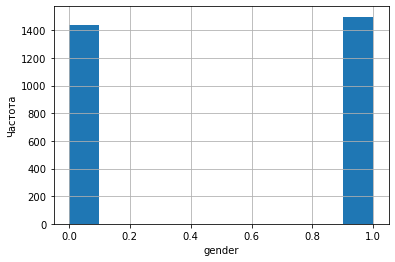

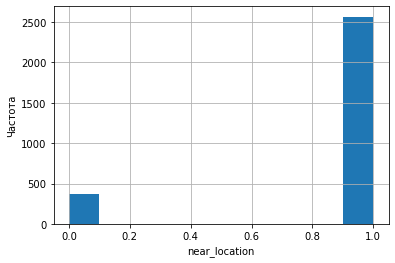

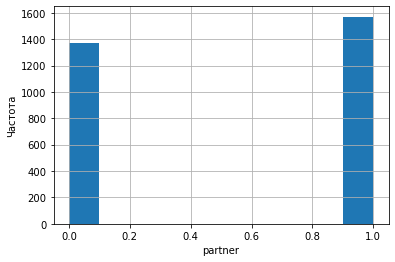

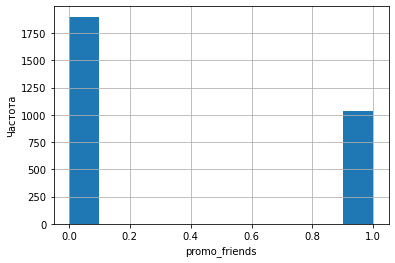

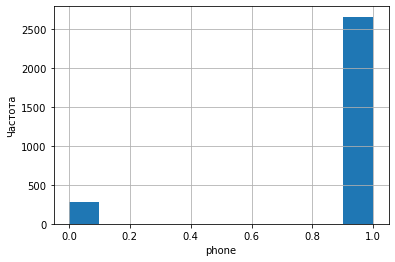

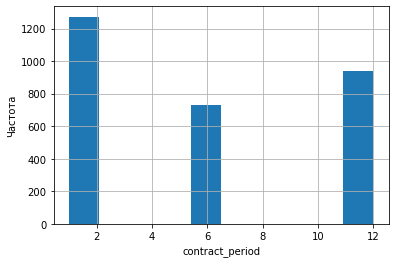

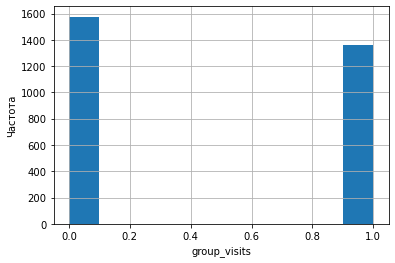

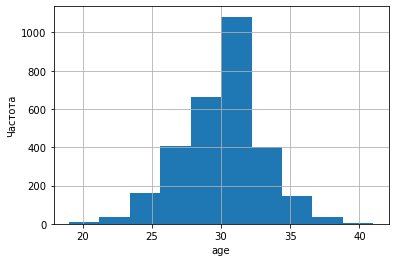

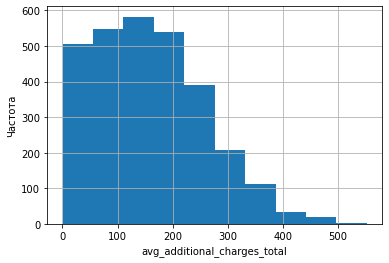

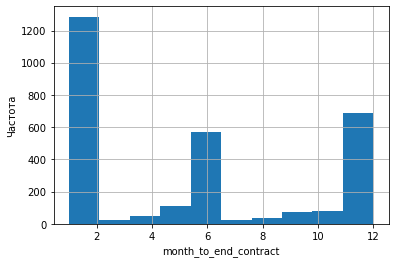

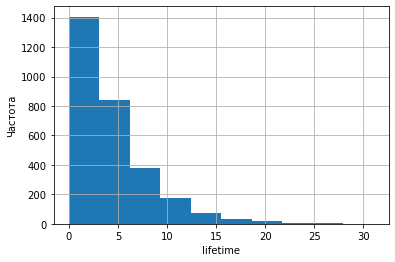

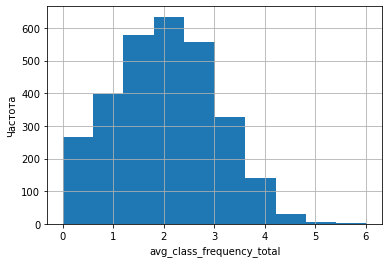

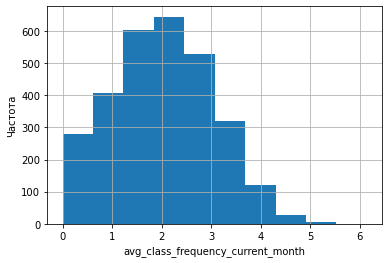

In [15]:
hist_plots(gym_data.query('churn == 0'))

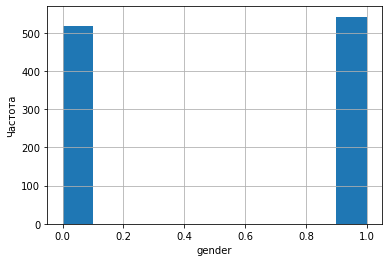

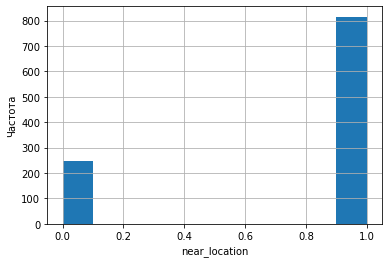

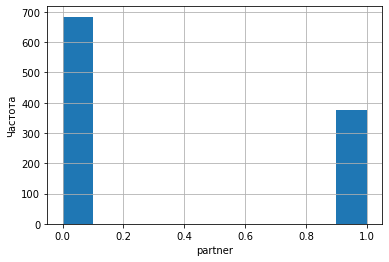

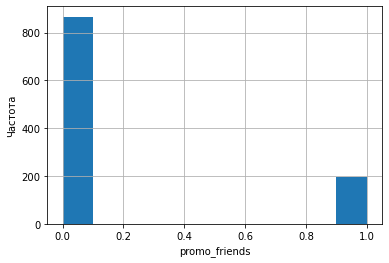

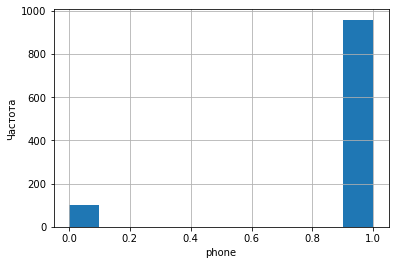

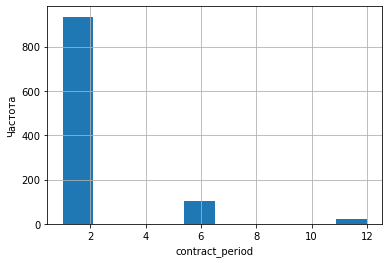

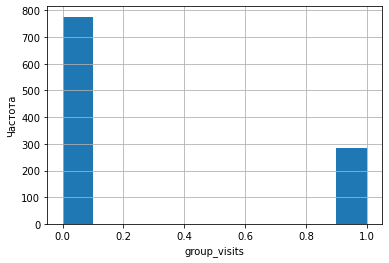

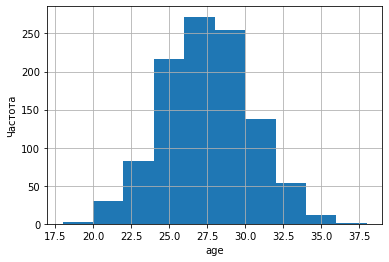

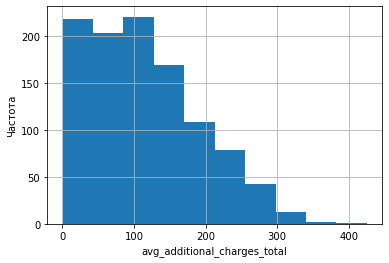

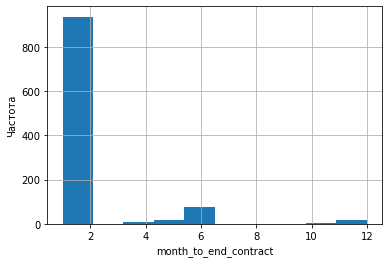

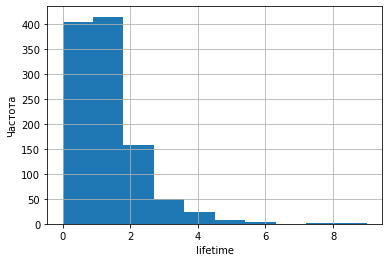

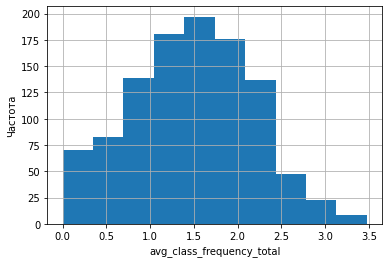

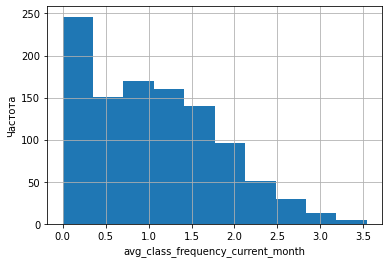

In [16]:
hist_plots(gym_data.query('churn == 1'))

🧑‍🎓 Ира: Можно заметить несколько различий среди групп клиентов:  
- Среди постоянных клиентов больше тех, кто пришел по абонементу от партнерской программы, в отскочивших наоборот;    
- постоянные клиенты берут абонемент на 6 мес и более чаще, чем на 1 месяц, в отскочивших наоборот; 
- отскочившие клиенты намного реже пользовались доп услугами фитнес-клуба;   
- А еще среди отскочивших у подовляющего большинства людей абонемент заканчивался в первые 2 месяца года.   
    
    
    По всем выше перечисленным наблюдениям можно сделать вывод, что отскочившие клиенты это те самые люди, которые начинают новую жизнь с понедельника, скорее всего они покупали абонемент в декабре по какой-то новогодней скидке и переставали пользоваться услугами фитнеса уже спустя месяц, максимум 2, так как покупка была явно импульсивная, т. е. это не было какое-то желание систематически ходить в зал, а просто очередная безделушка по акции.

In [17]:
def kde_plots(df):
    for col in df.columns:
        sns.kdeplot(df[col])
        plt.show()

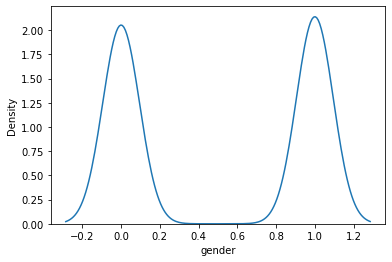

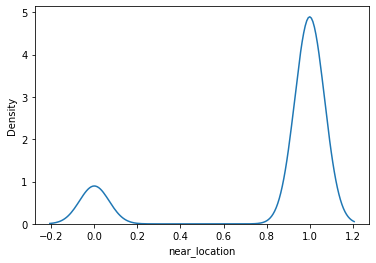

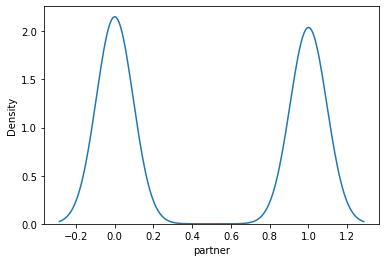

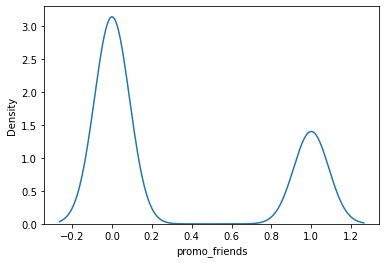

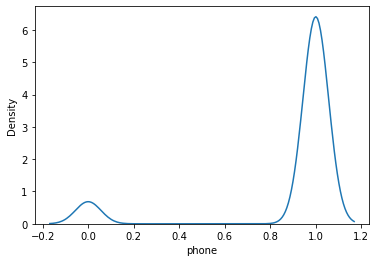

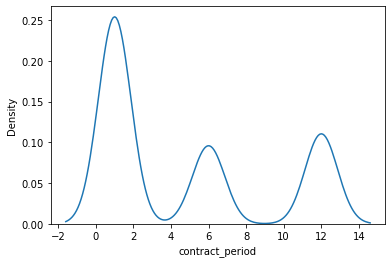

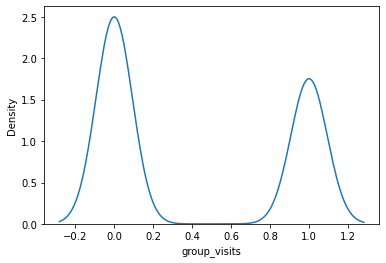

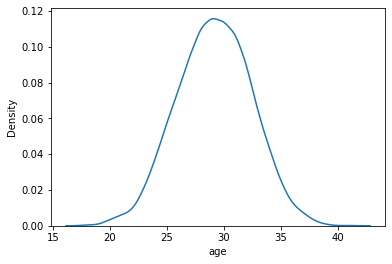

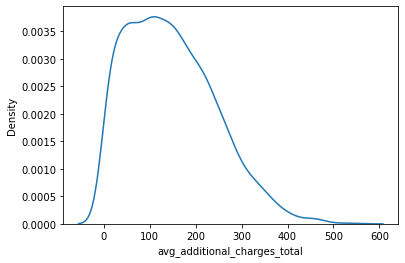

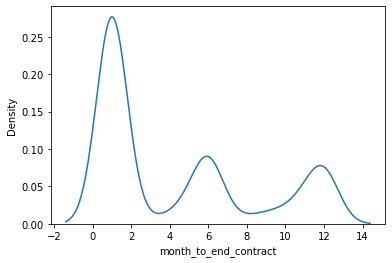

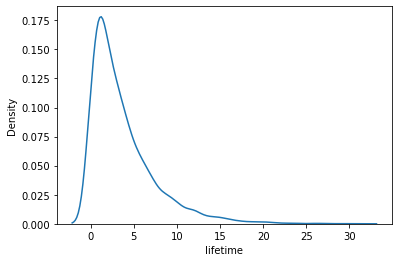

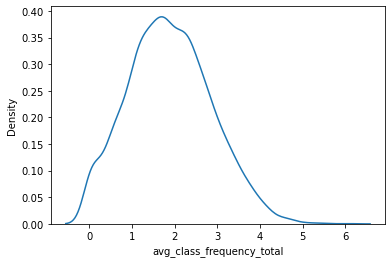

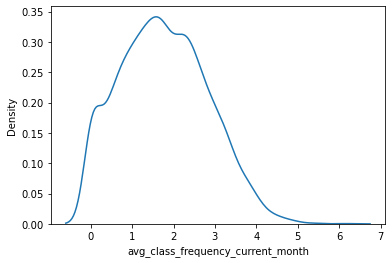

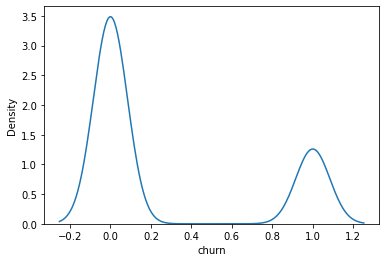

In [18]:
kde_plots(gym_data)

🧑‍🎓 Ира: на нормальное распределение похож только возраст

In [19]:
cm = gym_data.corr()

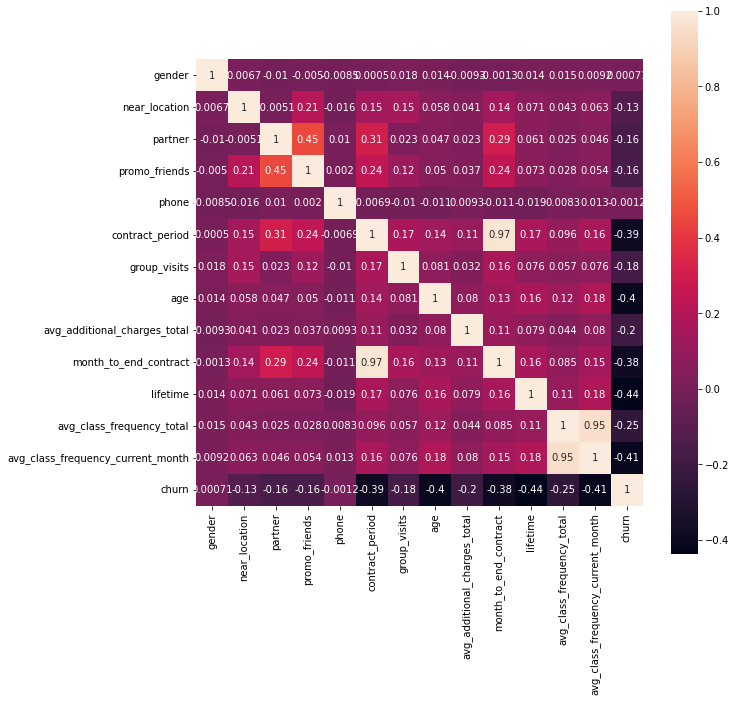

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, square=True)
plt.show()

🧑‍🎓 Ира: в датасете в принципе очень мало сильнокоррелируемых полей. Поля с периодом использования абонемента и месяцем, когда абонемент заканчивается коррелируют сильно, что логично.  
Кол-во посещений фитнеса в неделю и за все время тоже коррелирует логично, скорее всего люди, которые систематически ходят в зал, делают это с постоянной периодичностью

In [21]:
gym_data.drop('month_to_end_contract', axis = 1, inplace = True) 
gym_data.drop('avg_class_frequency_current_month', axis = 1, inplace = True) 

🧑‍🎓 Ира: здесь же разделим датасет на признаки и целевую переменную и стандартизируем данные.

In [22]:
print('Соотношение классов:\n', gym_data['churn'].value_counts())

Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


In [23]:
X = gym_data.drop(columns=['churn'], axis=1)
y = gym_data['churn']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

In [26]:
# применем стандартизацию к матрице признаков и для валидационной выборки
X_test_st = scaler.transform(X_test)

In [27]:
x_sc = scaler.fit_transform(X)

<div class="alert alert-info">

## Шаг 3. Постройте модель прогнозирования оттока клиентов

<div style="border:solid green 2px; padding: 20px">
<b>Задача</b>  
    
Разбейте данные на обучающую и валидационную выборку функцией train_test_split().  
    
Обучите модель на train-выборке двумя способами:   
логистической регрессией,  
случайным лесом.   
    
Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели.
    

In [28]:
models = [
    LogisticRegression(random_state=0, solver='liblinear'), 
    RandomForestRegressor(random_state = 0, n_estimators = 100)
]

In [29]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred.round()),
            precision_score(y_test, y_pred.round()),
            recall_score(y_test, y_pred.round()),
        )
    )

In [30]:
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test,
    )

LogisticRegression(random_state=0, solver='liblinear')
accuracy:0.90 precision:0.84 recall:0.80
RandomForestRegressor(random_state=0)
accuracy:0.91 precision:0.86 recall:0.80


🧑‍🎓 Ира:   
Так как соотношение классов не 50/50, судить по метрике accuracy будет неправильно, так как она чувствительна к балансу классов.   
    По метрике precision сложно сравнивать, так как на мо взгляд в данном случае она не подходит, да и среди классов она равна.   
    Если смотреть по метрике recall, то преимущество явно у случайного леса.   

<div class="alert alert-info">

## Шаг 4. Сделайте кластеризацию клиентов

In [31]:
linked = linkage(x_sc, method = 'ward')

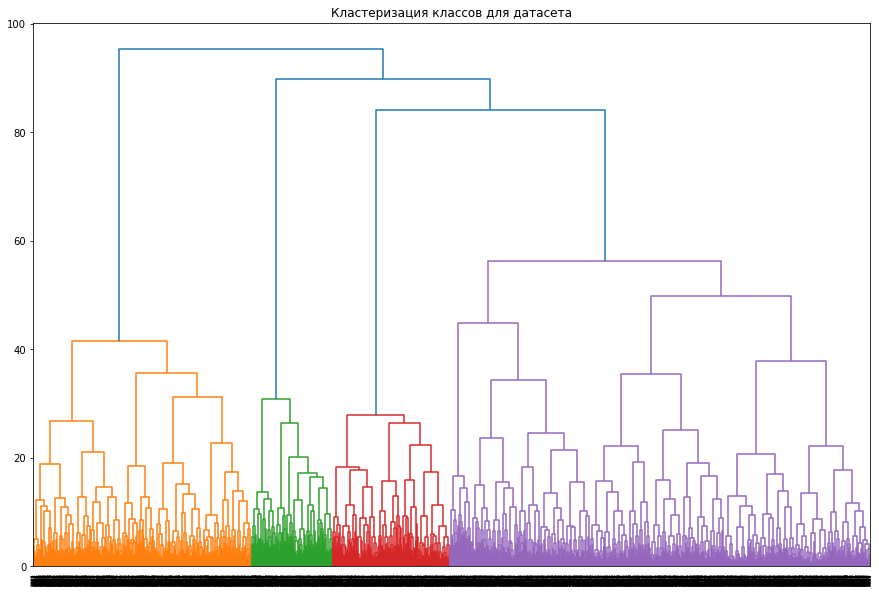

In [32]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация классов для датасета')
plt.show() 

In [33]:
km = KMeans(n_clusters=5, random_state=0) 

In [34]:
labels = km.fit_predict(x_sc)

In [35]:
gym_data['cluster_km'] = labels

In [36]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0,1
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0,1


In [37]:
clusters = gym_data.groupby(['cluster_km']).mean()
display(clusters)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster_km,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


🧑‍🎓 Ира: можно заметить, что одним из пограничных признаков могли стать признаки contract_period и month_to_end_contract, возраст практически не повлиял на разделение кластеров. 


Пол, возраст и признаки avg_additional_charges_total, avg_class_frequency_total распределены во всех кластерах примерно одинаково.

В кластерах, где отток клиентов больше, почти нет различий между признаками, но например признак partner почти в 2 раза ниже, чем у кластеров с низким оттоком, отчасти это же можно сказать и про принак promo_friends.    
Есть различия в признаке contract_period, так же среди этих класов можно увидеть четкое разделение на тех, кто ходит на групповые занятия и тех, кто не делает этого. 

У кластеров, не подверженных оттоку есть различия между признаками локации, среднего периода действия абонемента(но различия не здесь невелеки), при этом лайфтайм у этих кластеров в пределах 3-4,5. 


In [38]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

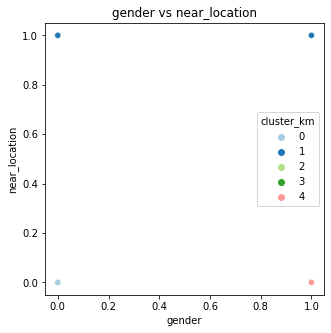

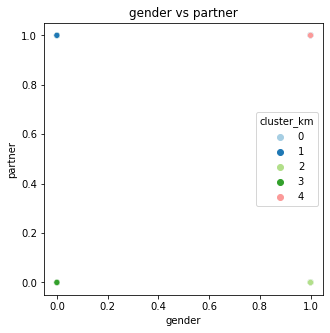

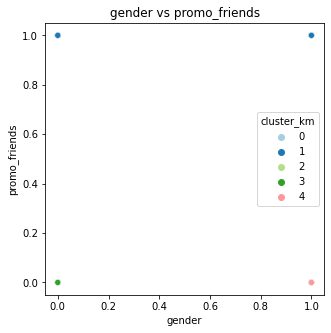

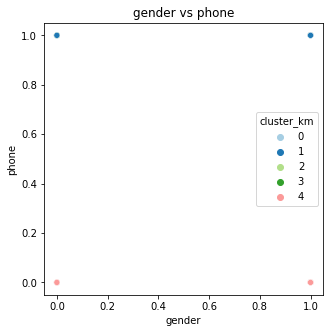

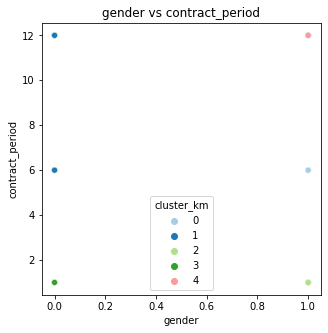

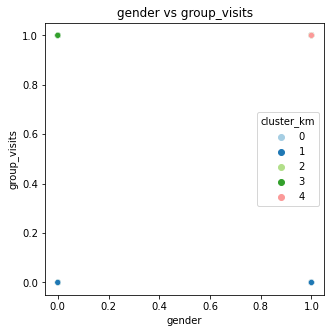

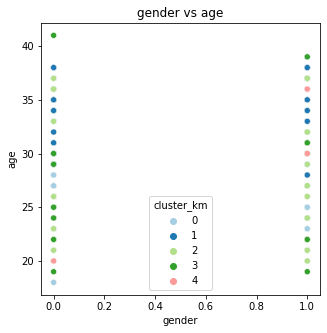

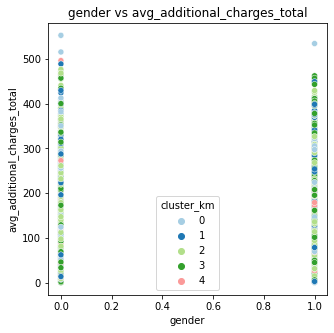

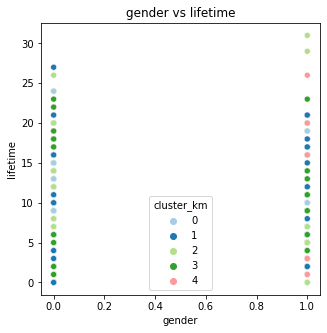

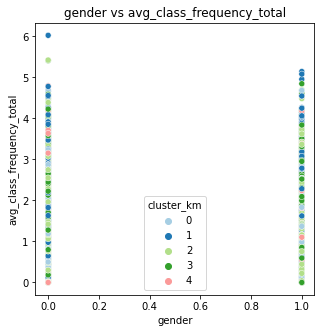

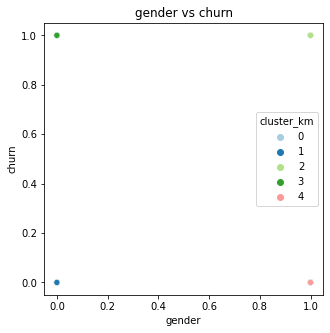

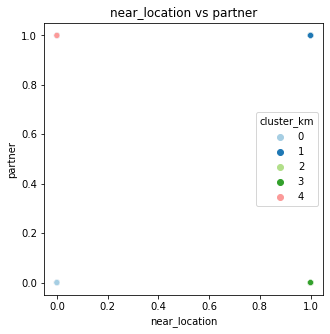

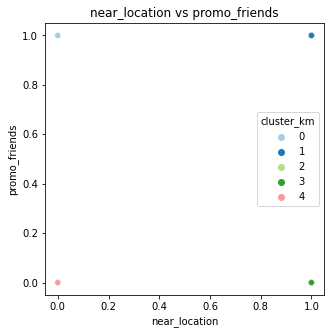

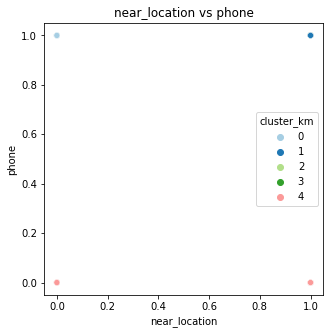

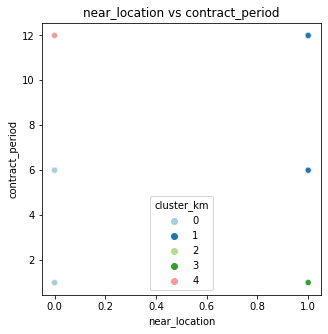

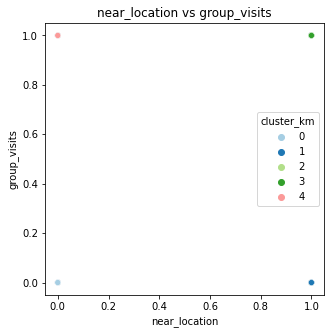

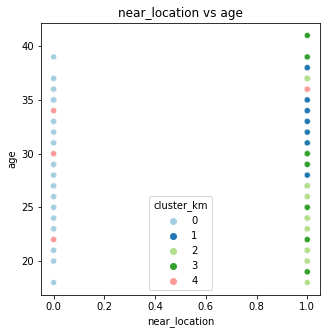

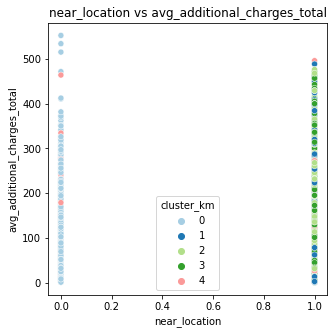

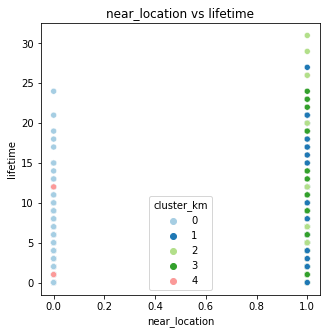

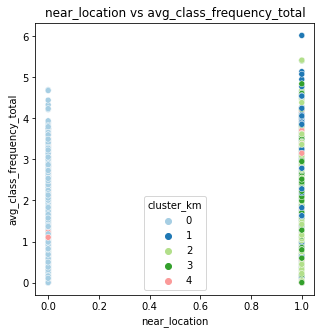

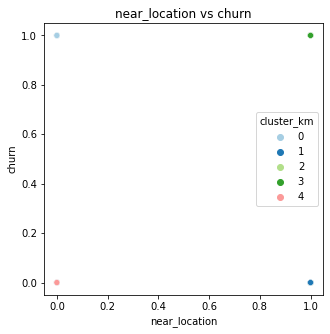

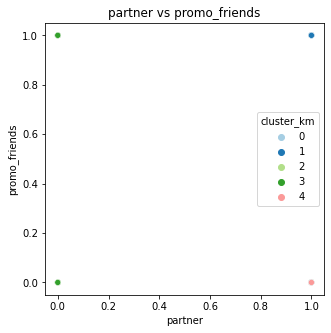

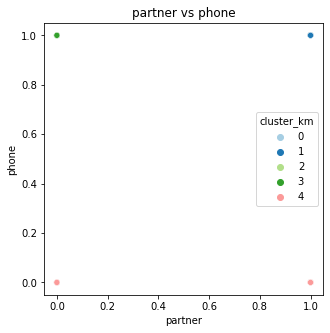

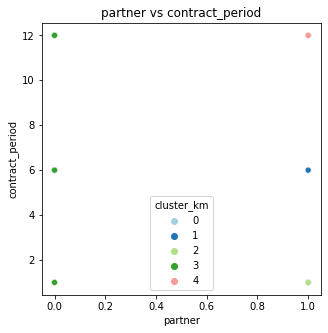

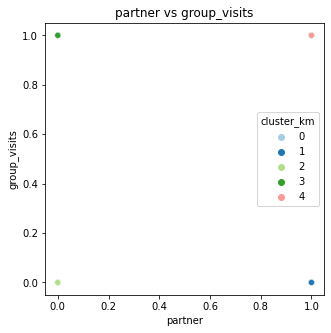

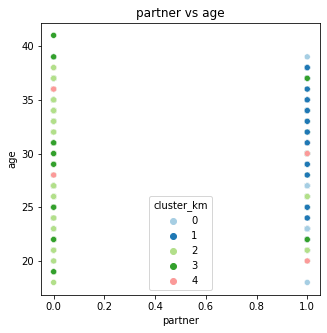

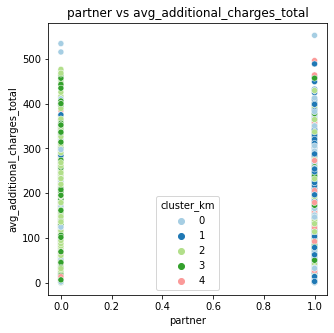

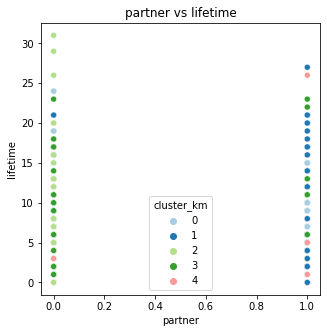

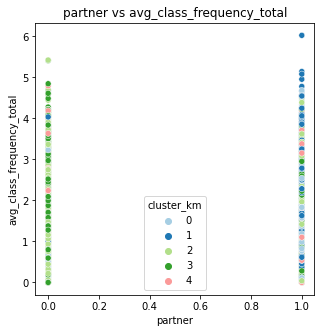

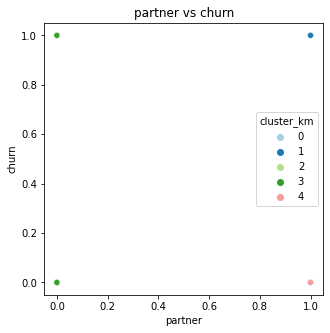

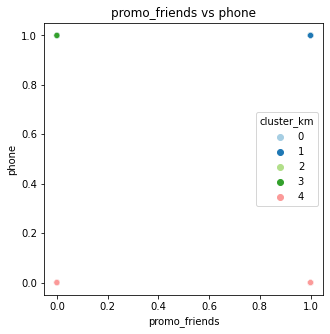

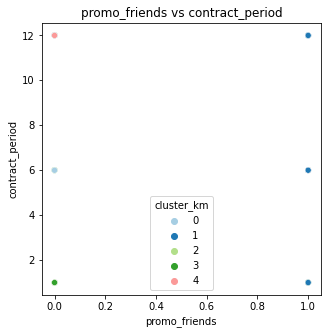

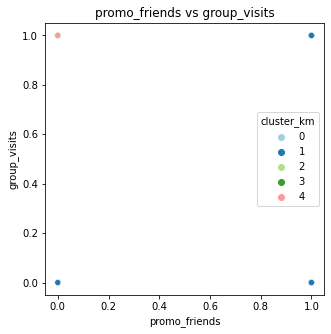

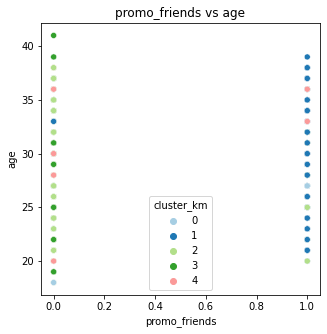

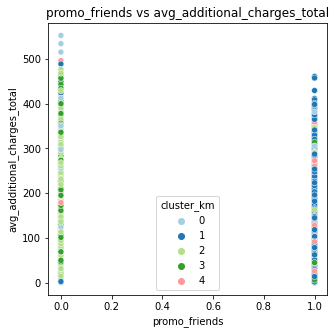

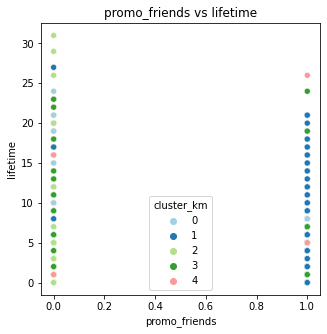

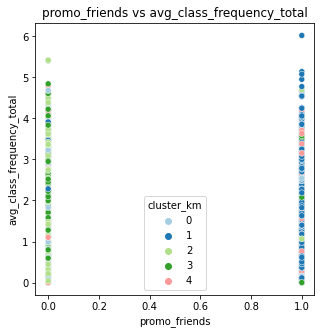

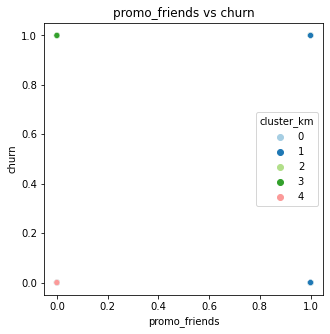

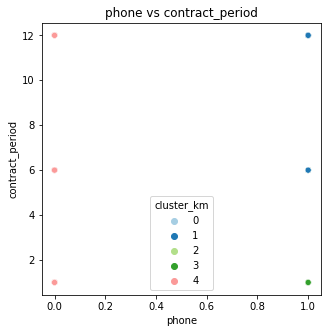

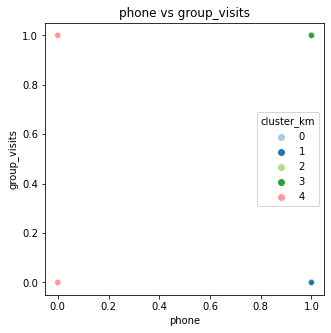

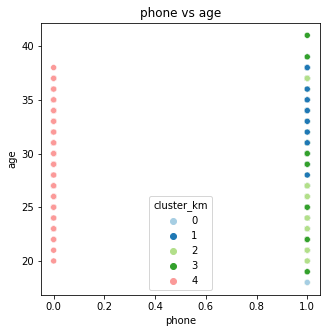

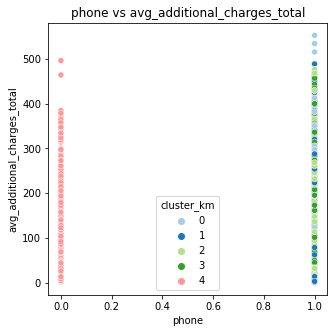

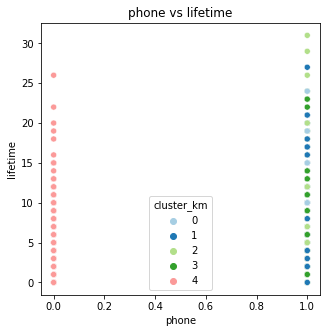

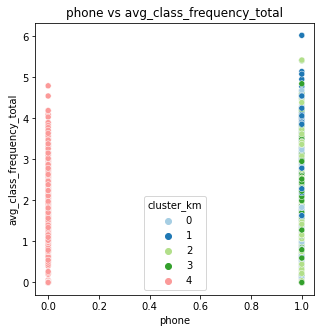

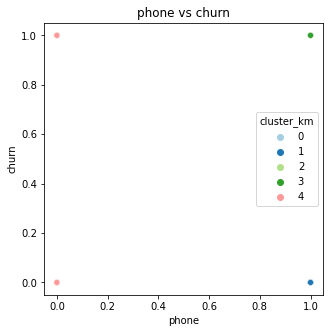

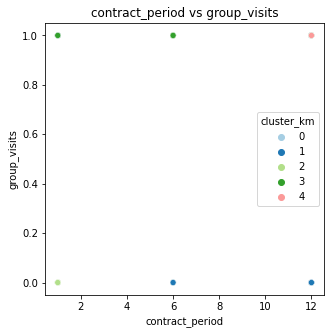

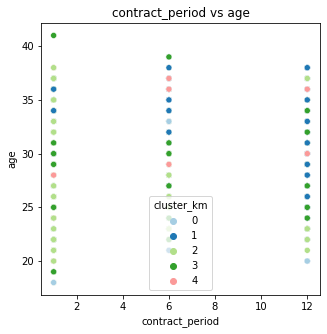

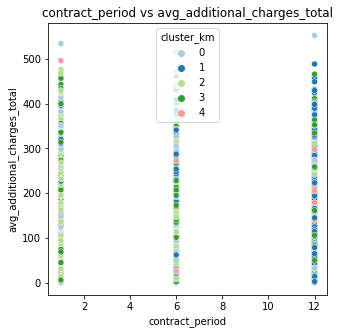

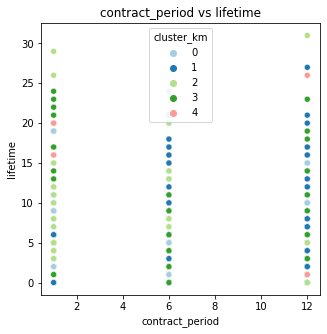

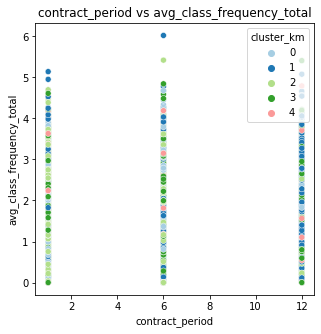

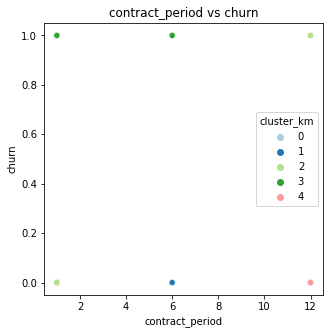

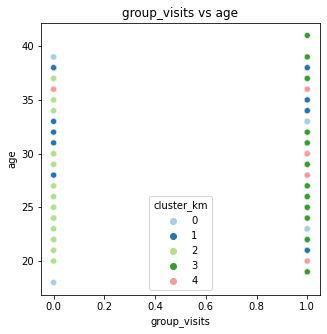

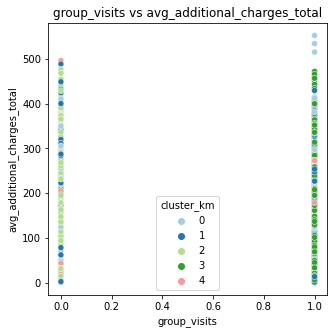

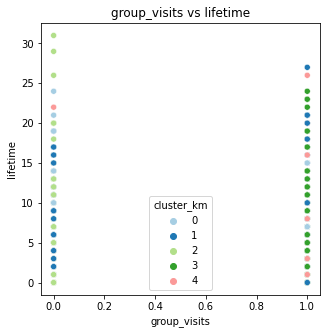

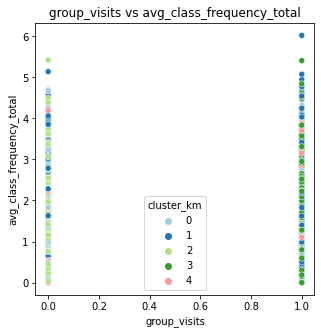

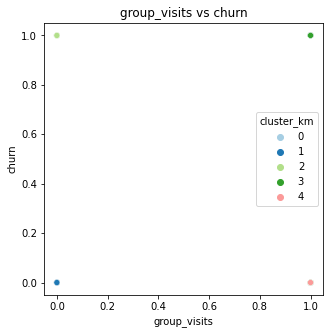

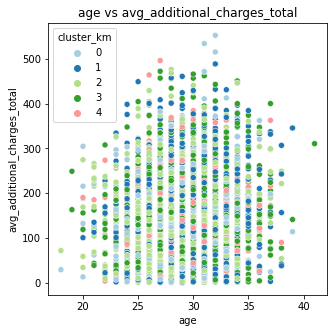

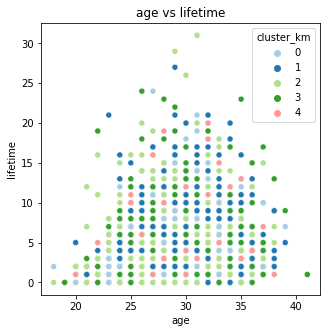

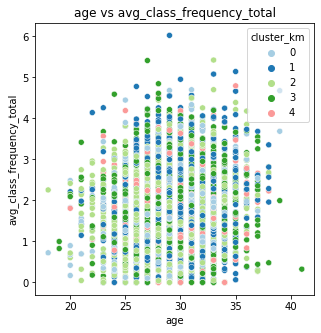

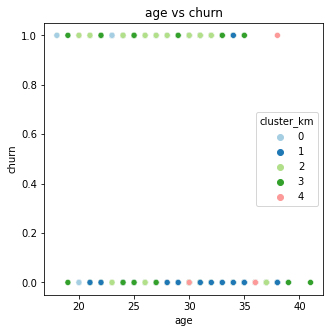

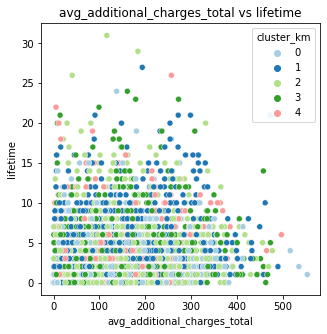

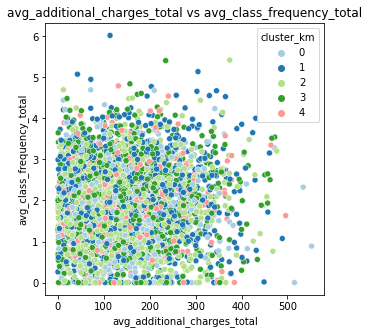

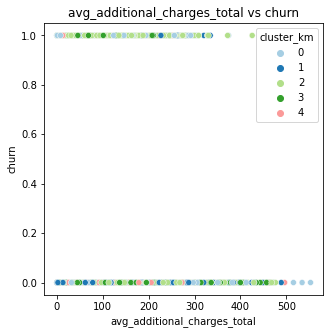

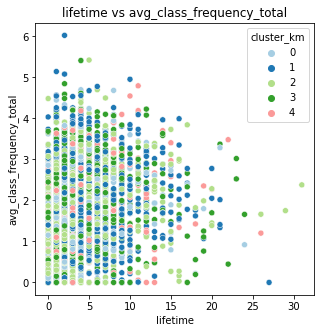

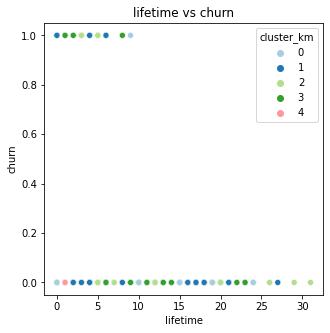

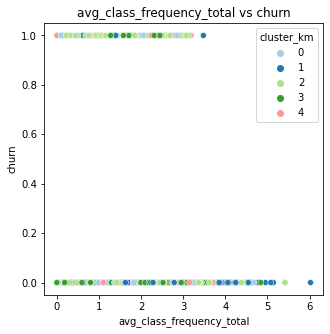

In [39]:
col_pairs = list(itertools.combinations(gym_data.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(gym_data, pair[0], pair[1], 'cluster_km')

🧑‍🎓 Ира: в принципе здесь тоже заметно, что пограничными значениями для кластеров были показатели длительности абонемента и месяца, когда абонемент заканчивается(но так как эти признаки сильно коррелируемые это наверное логично). Еще можно заметить, что показатели кол-ва посещений в неделю тоже "стараются быть" пограничными для кластеров.

In [40]:
cluster_churn = gym_data.groupby(['cluster_km'])['churn'].agg(['sum', 'count']).reset_index()
cluster_churn['churn_prop'] = cluster_churn['sum'] /  cluster_churn['count']
cluster_churn

,cluster_km,sum,count,churn_prop
0,0,224,561,0.399287
1,1,127,1050,0.120952
2,2,432,1132,0.381625
3,3,175,871,0.200918
4,4,103,386,0.266839


🧑‍🎓 Ира: Можно сказать, что кластеры 0, 1 и 4 почти не подвержены оттоку, а остальные кластеры подвержены ему больше

<div class="alert alert-info">

## Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

Видно, что люди чаще ходят в зал постянно, если покупают абонемент на большее кол-во месяцев, чем на 1 месяц, так же эти клиенты чаще приходят по партнерской программе. 

Мои рекомендации:  
- Делать скидку на абонементы от 6 месяцев, то есть например абонемент на 1 месяц = 3000, абонемент на 6 месяцев всего 18000 например за 15000 продавать;  
- Сделать акцент на акцию "Приведи друга", так как по ней так же очень много людей приходит и остаются надолго, может делать какие-то плюшки/бонусы для друга, которые привел нового клиента";  
- Дальше развивать партнерские программы.  
